In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causallib.datasets.data_loader import load_nhefs_survival
import lifelines
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from causallib.survival.weighted_survival import WeightedSurvival
from causallib.survival import StandardizedSurvival
from lifelines import CoxPHFitter

import warnings
warnings.filterwarnings('ignore')

### Loading the NHEFS dataset

In [2]:
# Load and pre-process NHEFS data
data = load_nhefs_survival()
nhefs = pd.concat([data.a, data.X, data.t, data.y], axis=1)
nhefs.shape

(1629, 21)

In [3]:
nhefs

,qsmk,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,...,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,longevity,death
0,0,42,1,0,30,29,79.04,False,False,False,...,False,False,False,True,1764,6247.3216,900,841,120.0,0
1,0,36,0,0,20,24,58.63,False,False,True,...,False,False,False,False,1296,3437.4769,400,576,120.0,0
2,0,56,1,1,20,26,56.81,False,False,True,...,False,False,False,True,3136,3227.3761,400,676,120.0,0
3,0,68,1,0,3,53,59.42,True,False,False,...,False,False,False,True,4624,3530.7364,9,2809,26.0,1
4,0,40,0,0,20,19,87.09,True,False,True,...,False,False,True,False,1600,7584.6681,400,361,120.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,0,45,0,0,40,29,63.05,False,False,False,...,False,False,False,False,2025,3975.3025,1600,841,120.0,0
1625,0,47,0,1,20,31,57.72,False,False,False,...,False,False,False,False,2209,3331.5984,400,961,120.0,0
1626,0,51,0,1,40,30,62.71,False,False,False,...,False,False,False,False,2601,3932.5441,1600,900,120.0,0
1627,0,68,0,0,15,46,52.39,True,False,False,...,False,False,True,False,4624,2744.7121,225,2116,120.0,0


In [4]:
nhefs.columns

Index(['qsmk', 'age', 'race', 'sex', 'smokeintensity', 'smokeyrs', 'wt71',
       'active_1', 'active_2', 'education_2', 'education_3', 'education_4',
       'education_5', 'exercise_1', 'exercise_2', 'age^2', 'wt71^2',
       'smokeintensity^2', 'smokeyrs^2', 'longevity', 'death'],
      dtype='object')

In [5]:
data['descriptors']

Variable name
active            IN YOUR USUAL DAY, HOW ACTIVE ARE YOU? IN 1971...
age                                                     AGE IN 1971
education         AMOUNT OF EDUCATION BY 1971: 1: 8TH GRADE OR L...
exercise          IN RECREATION, HOW MUCH EXERCISE? IN 1971, 0:m...
race                             0: WHITE 1: BLACK OR OTHER IN 1971
sex                                               0: MALE 1: FEMALE
smokeintensity          NUMBER OF CIGARETTES SMOKED PER DAY IN 1971
smokeyrs                                           YEARS OF SMOKING
wt71                                   WEIGHT IN KILOGRAMS  IN 1971
qsmk              QUIT SMOKING BETWEEN 1ST QUESTIONNAIRE AND 198...
wt82_71                                  WEIGHT CHANGE IN KILOGRAMS
Name: Description, dtype: object

### EDA analysis

In [6]:
X = data.X
A = nhefs['qsmk']
Y = nhefs['death']
T = nhefs['longevity']

In [7]:
(Y==1).sum()

np.int64(318)

In [8]:
A.value_counts(normalize=True)

qsmk
0    0.737262
1    0.262738
Name: proportion, dtype: float64

In [9]:
np.round(pd.crosstab(A, Y, normalize='index')*100, 2)

death,0,1
qsmk,,
0,82.01,17.99
1,76.17,23.83


In [10]:
nhefs.groupby('qsmk')[['age', 'sex', 'race', 'exercise_2', 'active_2']].mean().round(2)

,age,sex,race,exercise_2,active_2
qsmk,,,,,
0,42.92,0.53,0.15,0.38,0.09
1,46.70,0.45,0.09,0.41,0.11


### Causal survival analysis

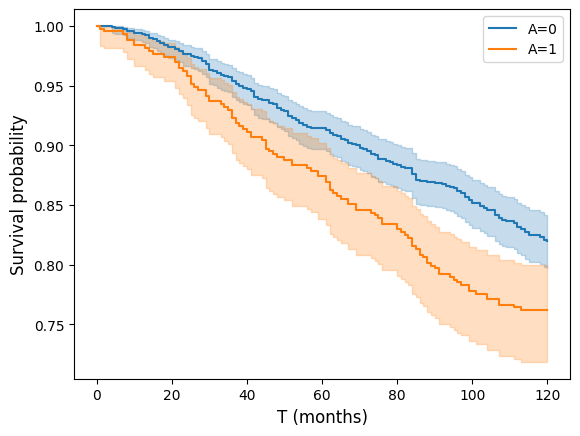

In [11]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations=T[A == 0], event_observed=Y[A == 0], label="A=0")
kmf.plot_survival_function()
kmf.fit(durations=T[A == 1], event_observed=Y[A == 1], label="A=1")
kmf.plot_survival_function()
plt.xlabel("T (months)", fontsize=12)
plt.ylabel("Survival probability", fontsize=12)
plt.show()

### Estimation using Inverse Probability Weighting 

In [12]:
learner = LogisticRegression(penalty=None, solver='lbfgs',
                             max_iter=5000)
ipw = IPW(learner)
ipw.fit(X, A)
propensity_scores = ipw.compute_propensity(X, A, treatment_values=1)
print(propensity_scores)

0       0.107488
1       0.161227
2       0.135014
3       0.446085
4       0.276189
          ...   
1624    0.173549
1625    0.146316
1626    0.131917
1627    0.495877
1628    0.184031
Name: 1, Length: 1629, dtype: float64


In [13]:
weights = ipw.compute_weights(X, A)
print(weights)

0       1.120433
1       1.192218
2       1.156088
3       1.805330
4       1.381575
          ...   
1624    1.209993
1625    1.171394
1626    1.151964
1627    1.983643
1628    5.433867
Length: 1629, dtype: float64


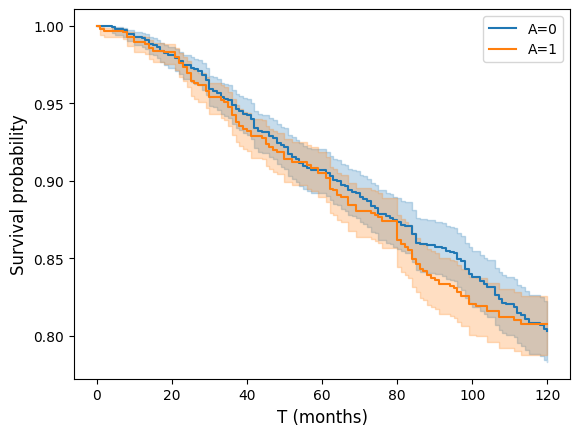

In [14]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations=T[A==0], event_observed=Y[A==0], weights=weights[A==0],   
        label="A=0")
kmf.plot_survival_function()  
kmf.fit(durations=T[A==1], event_observed=Y[A==1], weights=weights[A==1],   
        label="A=1")
kmf.plot_survival_function()  

plt.xlabel("T (months)", fontsize=12)
plt.ylabel("Survival probability", fontsize=12)
plt.show()

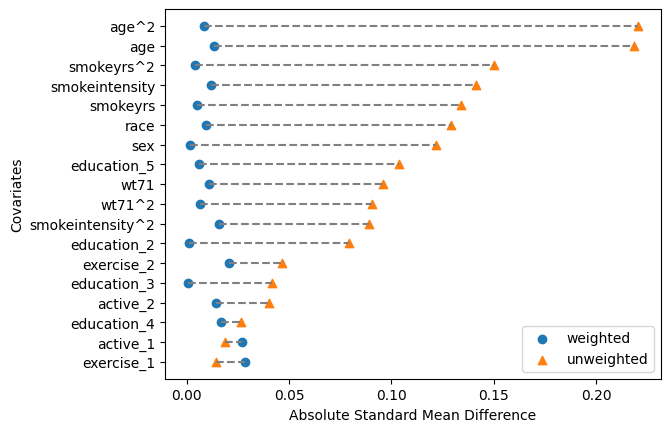

In [15]:
evaluation_results = evaluate(ipw, X, A, Y)
evaluation_results.plot_covariate_balance(kind="love")
plt.show()

### Estimation using Standardization

In [16]:
cph = CoxPHFitter()
cph.fit(nhefs, duration_col='longevity', event_col='death')

print(cph.params_)

covariate
qsmk                0.028795
age                 0.081665
race                0.047359
sex                -0.436450
smokeintensity     -0.000086
smokeyrs            0.019047
wt71               -0.061347
active_1            0.160250
active_2            0.234973
education_2        -0.132926
education_3        -0.433116
education_4        -0.228105
education_5        -0.381206
exercise_1         -0.140340
exercise_2          0.155111
age^2              -0.000027
wt71^2              0.000399
smokeintensity^2    0.000085
smokeyrs^2          0.000015
Name: coef, dtype: float64


In [17]:
print(cph.baseline_hazard_)

       baseline hazard
1.0           0.000260
2.0           0.000261
4.0           0.000262
5.0           0.000263
7.0           0.000527
...                ...
114.0         0.001597
115.0         0.001608
118.0         0.001076
119.0         0.001615
120.0         0.000549

[109 rows x 1 columns]


In [18]:
print(len(np.unique(nhefs['longevity'])))

109


In [19]:
survival_curve = cph.predict_survival_function(nhefs[cph.params_.index].iloc[[0]])
survival_curve

,0
1.0,0.999601
2.0,0.999201
4.0,0.998799
5.0,0.998397
7.0,0.997590
...,...
114.0,0.836746
115.0,0.834686
118.0,0.833311
119.0,0.831251


In [20]:
cph = CoxPHFitter()
cph.fit(nhefs, duration_col="longevity", event_col="death")
pop_avg_survival_curves = {}
for a in [0, 1]:
    temp = nhefs.copy()
    temp["qsmk"] = a
    ind_surv_curves = cph.predict_survival_function(temp)
    pop_avg_survival_curves[a] = ind_surv_curves.mean(axis=1)

In [21]:
pop_avg_survival_curves[0]

1.0      0.999393
2.0      0.998786
4.0      0.998176
5.0      0.997567
7.0      0.996350
           ...   
114.0    0.812805
115.0    0.810947
118.0    0.809710
119.0    0.807866
120.0    0.807241
Length: 109, dtype: float64

In [22]:
pop_avg_survival_curves[1]

1.0      0.999375
2.0      0.998750
4.0      0.998123
5.0      0.997496
7.0      0.996244
           ...   
114.0    0.808895
115.0    0.807010
118.0    0.805756
119.0    0.803885
120.0    0.803252
Length: 109, dtype: float64

In [23]:
standardized_survival_cox = StandardizedSurvival(survival_model=lifelines.CoxPHFitter())
standardized_survival_cox.fit(X, A, T, Y)
pop_avg_survival_curves = standardized_survival_cox.estimate_population_outcome(X, A, T)
pop_avg_survival_curves

qsmk,0,1
longevity,,
1.0,0.999062,0.998249
2.0,0.999062,0.996486
3.0,0.999062,0.996130
4.0,0.999062,0.995774
5.0,0.998123,0.995420
...,...,...
116.0,0.809910,0.810058
117.0,0.809308,0.810058
118.0,0.808708,0.810058


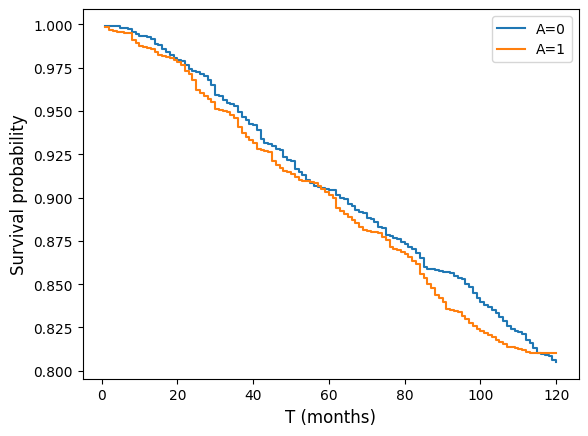

In [24]:
plt.step(pop_avg_survival_curves.index, 
         pop_avg_survival_curves[0].values,
         where="post", label="A=0")
plt.step(pop_avg_survival_curves.index, 
         pop_avg_survival_curves[1].values,
         where="post", label="A=1")
plt.legend()
plt.xlabel("T (months)", fontsize=12)
plt.ylabel("Survival probability", fontsize=12)
plt.show()